In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV, KFold 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Data Preparation

In [2]:
df = pd.read_csv('./data/car_insurance_premium_dataset.csv')
df.head()

,Driver Age,Driver Experience,Previous Accidents,Annual Mileage (x1000 km),Car Manufacturing Year,Car Age,Insurance Premium ($)
0,56,32,4,17,2002,23,488.35
1,46,19,0,21,2025,0,486.15
2,32,11,4,15,2020,5,497.55
3,60,0,4,19,1991,34,498.35
4,25,7,0,13,2005,20,495.55


Checking the type of the records.

In [3]:
df.dtypes

Driver Age                     int64
Driver Experience              int64
Previous Accidents             int64
Annual Mileage (x1000 km)      int64
Car Manufacturing Year         int64
Car Age                        int64
Insurance Premium ($)        float64
dtype: object

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Driver Age                 1000 non-null   int64  
 1   Driver Experience          1000 non-null   int64  
 2   Previous Accidents         1000 non-null   int64  
 3   Annual Mileage (x1000 km)  1000 non-null   int64  
 4   Car Manufacturing Year     1000 non-null   int64  
 5   Car Age                    1000 non-null   int64  
 6   Insurance Premium ($)      1000 non-null   float64
dtypes: float64(1), int64(6)
memory usage: 54.8 KB


In [5]:
df.describe()

,Driver Age,Driver Experience,Previous Accidents,Annual Mileage (x1000 km),Car Manufacturing Year,Car Age,Insurance Premium ($)
count,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000,1000.000000,1000.000000
mean,41.575000,14.759000,2.5680,17.933000,2007.637000,17.363000,493.742250
std,13.765677,10.544292,1.6989,4.410665,10.363331,10.363331,5.909689
min,18.000000,0.000000,0.0000,11.000000,1990.000000,0.000000,477.050000
25%,30.000000,6.000000,1.0000,14.000000,1999.000000,8.000000,489.487500
50%,42.000000,13.000000,3.0000,18.000000,2008.000000,17.000000,493.950000
75%,53.000000,23.000000,4.0000,22.000000,2017.000000,26.000000,498.312500
max,65.000000,40.000000,5.0000,25.000000,2025.000000,35.000000,508.150000


The dataset consists only of numerical features with `Insurance Premium ($)` being a target variable.

To make it easier to call the feature we will rename the column with a lowercase and snake case style. 

We will take a look through the EDA down below.

In [6]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [7]:
df.columns

Index(['driver_age', 'driver_experience', 'previous_accidents',
       'annual_mileage_(x1000_km)', 'car_manufacturing_year', 'car_age',
       'insurance_premium_($)'],
      dtype='object')

# Explanatory Data Analysis (EDA)

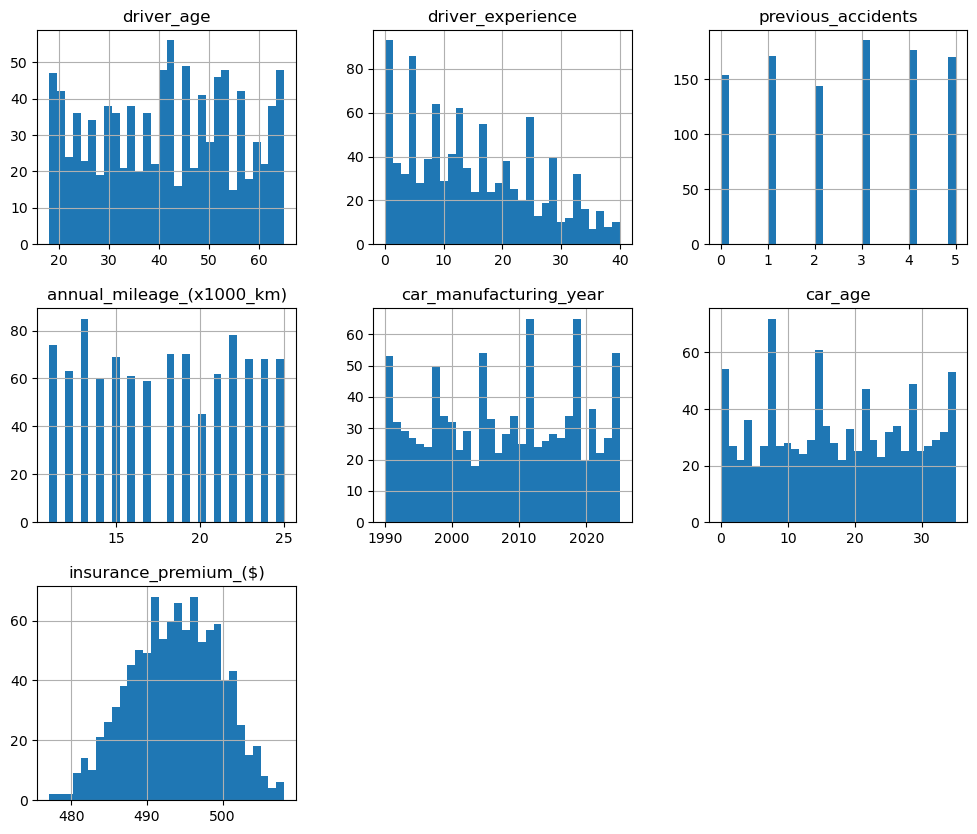

In [8]:
df.hist(bins=30, figsize=(12,10))
plt.show()

The data distribution is quite even for every features.

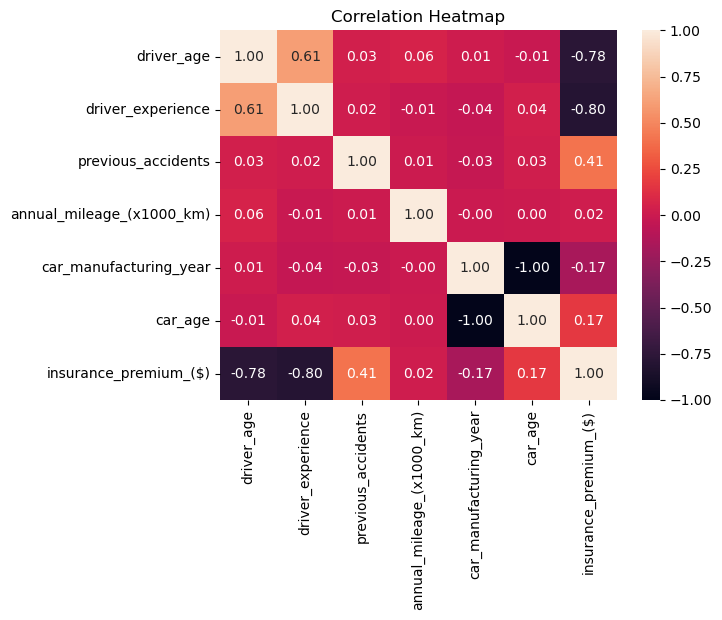

In [9]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Driver age and experience show strong negative correlation with the insurance premium.

# Set Up Validation Framework

Since we already prepared the test dataset, we only split the dataset into training and validation. 
The dataset will be split using KFold Cross-Validation for parameter tuning in the next step.

In [10]:
cv = KFold(n_splits=5, shuffle=True, random_state=8)

In [11]:
X_train = df.drop(columns='insurance_premium_($)')
y_train = df['insurance_premium_($)'].values

Since the features are in different magnitudes we need to standardise the scale.  

In [12]:
scaler_x = StandardScaler()
scaler_x.fit(X_train)

X_train_scaled = scaler_x.transform(X_train)

In [13]:
scaler_y = StandardScaler()

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1))

### Preparing Test Data

In [2]:
test_data = pd.read_csv('./data/car_insurance_premium_dataset_TEST.csv')
test_data.head()

,Driver Age,Driver Experience,Previous Accidents,Annual Mileage (x1000 km),Car Manufacturing Year,Car Age,Insurance Premium ($)
0,56,7,0,22,2009,16,489.40
1,46,23,2,21,1990,35,491.45
2,32,10,5,13,1997,28,501.55
3,60,16,1,16,2005,20,487.50
4,25,7,4,17,2003,22,501.95


In [5]:
test_data.columns = test_data.columns.str.lower().str.replace(' ', '_')
test_data.columns

Index(['driver_age', 'driver_experience', 'previous_accidents',
       'annual_mileage_(x1000_km)', 'car_manufacturing_year', 'car_age',
       'insurance_premium_($)'],
      dtype='object')

In [16]:
X_test = test_data.drop(columns='insurance_premium_($)')
y_test = test_data['insurance_premium_($)'].values

In [17]:
X_test_scaled = scaler_x.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1))

# Model Training & Parameter Tuning

In [18]:
# evaluation function
def eval(y_true, y_pred):

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    return round(rmse, 3), round(r2, 3)

### SVR

In [19]:
param_grid_svr = {'C': [0.1, 1, 10],
              'epsilon': [0.01, 0.1, 1]}

In [20]:
grid_svr = GridSearchCV(
    SVR(),
    param_grid_svr,
    scoring='neg_root_mean_squared_error',
    cv=cv,
)

In [21]:
grid_svr.fit(X_train_scaled, y_train_scaled.ravel())

GridSearchCV(cv=KFold(n_splits=5, random_state=8, shuffle=True),
             estimator=SVR(),
             param_grid={'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1, 1]},
             scoring='neg_root_mean_squared_error')

In [22]:
print(f"Best parameters: {grid_svr.best_params_}")
print(f"Best score: {grid_svr.best_score_}")

Best parameters: {'C': 10, 'epsilon': 0.01}
Best score: -0.019798227405508923


In [24]:
y_pred_scaled = grid_svr.predict(X_test_scaled)

In [25]:
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_pred = y_pred.ravel()

In [26]:
print(f"RMSE: {eval(y_test, y_pred)[0]}; R2_score: {eval(y_test, y_pred)[1]}")

RMSE: 0.069; R2_score: 1.0


### Random Forest Regressor

In [27]:
param_grid_rf = {
    'n_estimators': [50, 100, 200], 
    'max_depth': [None, 10, 20],  
}

In [28]:
grid_rf = GridSearchCV(
    RandomForestRegressor(),
    param_grid_rf,
    scoring='neg_root_mean_squared_error',
    cv=cv,
)

In [29]:
grid_rf.fit(X_train_scaled, y_train_scaled.ravel())

GridSearchCV(cv=KFold(n_splits=5, random_state=8, shuffle=True),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 10, 20],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_root_mean_squared_error')

In [30]:
print(f"Best parameters: {grid_rf.best_params_}")
print(f"Best score: {grid_rf.best_score_}")

Best parameters: {'max_depth': None, 'n_estimators': 200}
Best score: -0.12569457743673274


In [31]:
y_pred_scaled = grid_rf.predict(X_test_scaled)

In [32]:
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_pred = y_pred.ravel()

In [33]:
print(f"RMSE: {eval(y_test, y_pred)[0]}; R2_score: {eval(y_test, y_pred)[1]}")

RMSE: 0.785; R2_score: 0.981


# Training & Saving Final Model

In [34]:
# model training
model = SVR(C=10, epsilon=0.01)
model.fit(X_train_scaled, y_train_scaled.ravel())

# model prediction
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).ravel()

In [35]:
print(f"RMSE: {eval(y_test, y_pred)[0]}; R2_score: {eval(y_test, y_pred)[1]}")

RMSE: 0.069; R2_score: 1.0


In [36]:
output_file = f'model_C=10.bin'

In [37]:
with open(output_file, 'wb') as f_out:
    pickle.dump((scaler_x, scaler_y, model), f_out)